In [97]:
import sys
import healpy as hp
from astropy import units
import matplotlib.pyplot as plt
import numpy as np
import mf_2d as m2
import mf_1d as m1

sys.path.append('/Users/rebeccaceppas/Desktop/CHORD/spatial_matched_filter')

import maps

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define resolution of map

In [69]:
nside = 128
resolution = (hp.nside2resol(nside) * units.rad).to(units.deg).value

# Initialize an input map and create a 2d map

Text(0, 0.5, 'dec')

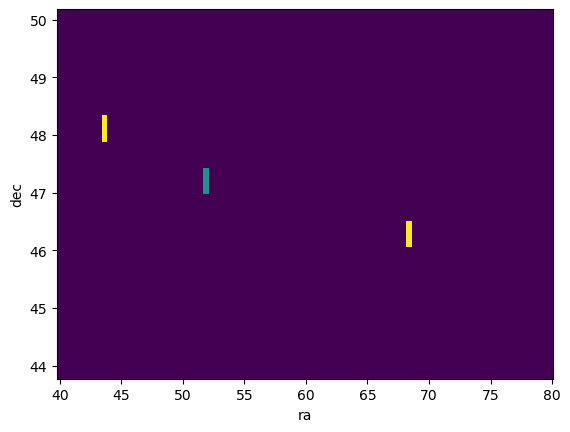

In [112]:
input_map = maps.InputMap(ra_max=80, ra_min=40, 
                          dec_max=50, dec_min=44,
                          nsources=3, 
                          resolution=resolution)

map2d = input_map.get_2d_map(brightness=[1,1,0.5])

plt.pcolor(input_map.ra, input_map.dec, map2d)
plt.xlabel('ra')
plt.ylabel('dec')

# Add instrumental effects

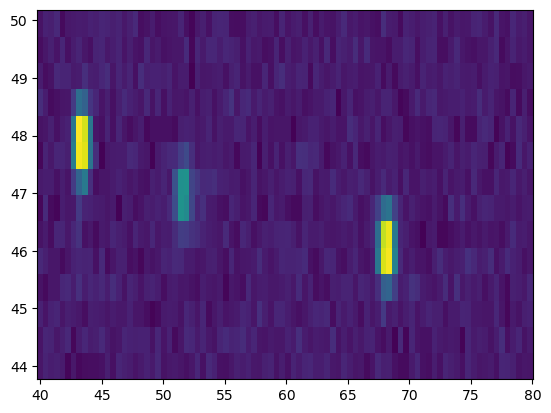

In [113]:
beam2d = input_map.get_2d_beam(maps.gaussian_beam, 1)

map_obs = input_map.observe(map2d, beam2d, add_noise=True, noise_std=3e-2)

plt.pcolor(input_map.ra, input_map.dec, map_obs)
plt.show()

# Turn into 1d map

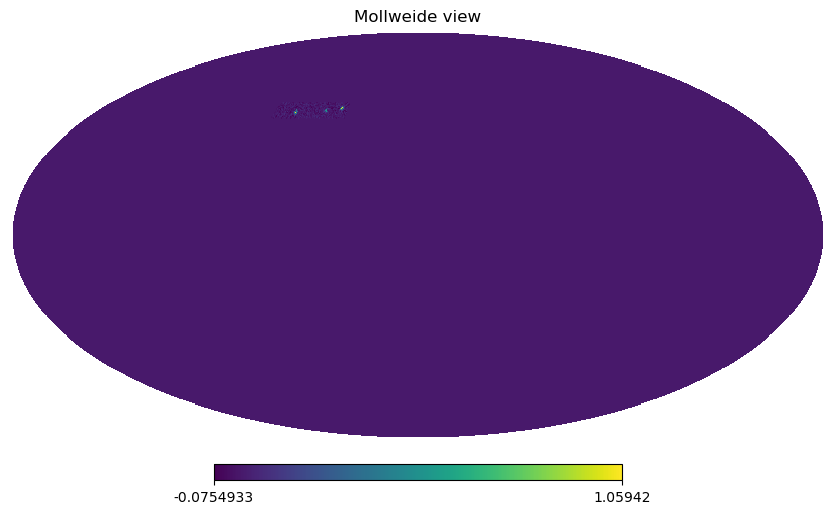

In [114]:
map1d_obs = input_map.get_1d_map(nside=nside, map_2d=map_obs)
map1d = input_map.get_1d_map(nside=nside, map_2d=map2d)
hp.mollview(map1d_obs)

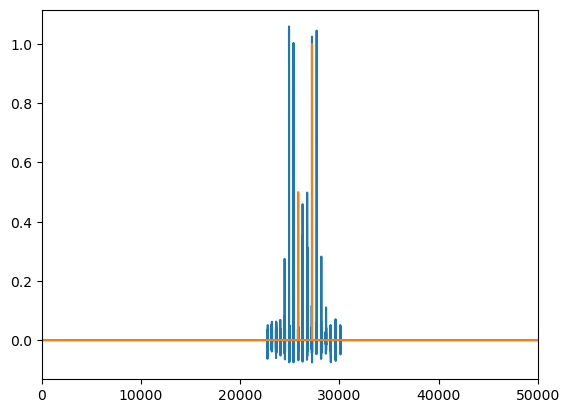

In [116]:
plt.plot(map1d_obs)
plt.plot(map1d)
plt.xlim(0,50000)
plt.show()

In [117]:
beam1d = input_map.get_1d_map(nside, beam2d)

# 2D matched filter

In [125]:
mf2d = np.fft.ifftshift(
    np.fft.ifft2(
        np.fft.fftshift(
            np.fft.fft2(map_obs) * np.fft.fft2(beam2d)
    )))

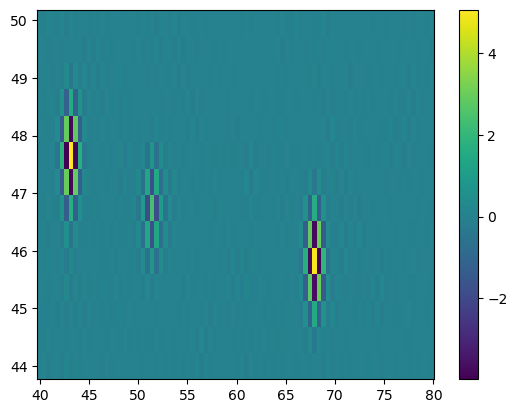

In [126]:
plt.pcolor(input_map.ra, input_map.dec, mf2d.real)
plt.colorbar()
plt.show()

# 1D matched filter

In [128]:
mf1d = np.fft.ifftshift(
    np.fft.ifft(
        np.fft.fftshift(
            np.fft.fft(map1d_obs) * np.fft.fft(beam1d)
    )))

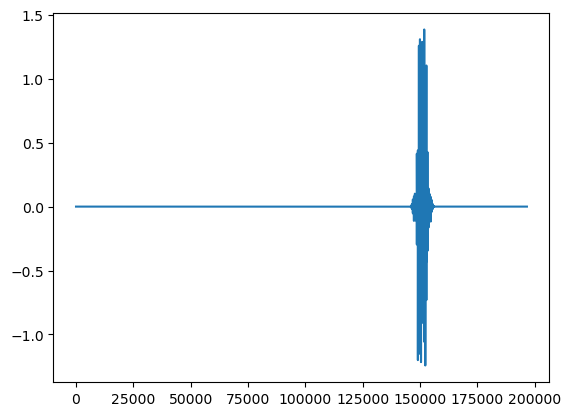

In [130]:
plt.plot(mf1d.real)